# Week of 2025.04.07

Goals for this week: 
- [ ] Use lumped parameter model to help narrow down on valid parameters for euruption Mario is looking at. 
- [x] Answer any questions Mario has about use of slip modeling tools. 
- [ ] Run input simulation with added atmospheric model. Our longterm goal here is to add an additional validation source for our model. At the moment when we run the simulation with the atmosphere we get a 'notPhysical' error. It also takes a very large number of timesteps which seems incorrect. 


## 1.0 Baseline model simulation to make sure that the PRs I merged in recently did not break anything obvious

Mario expects the volcano eruption we are modeling to happen on the order of 1s. In order to have our toy problem better match that short timescale eruption, I am reducing the time frame of the eruption by increasing the pressure in the melt. 

$\tau_{peak} = 1e6$

$$
p_0 = p_{atm} + \frac{2 L \tau_p}{R} \\
p_0 = 1e5 + \frac{2 * 50 [m] * 1e6 [Pa]}{10 [m]} \\
p_0 = 10.1 MPa
$$

From our analysis on $D_c$ (ignoring viscous drag and assuming quasi static pressure drop) we know:

$$
\begin{align}
D_c &< \frac{2 L_{conduit} L_{plug} (\tau_p - \tau_r)}{R K } \\
D_c &< \frac{2 * 950m * 50m * 1e6 Pa}{10m * 1e9 Pa}  \\
D_c &< 9.5m
\end{align}
$$

We can see that when $D_c$ is slightly greater than the 9.5m limit and $p_0$ is slightly less than 10 MPa

In [1]:
from slip_imports import *

ani = animate.animate_conduit_pressure("slip_variable_addition", iterations=25, file_prefix="short_plug_v11", p0=10.1, slip_final=7, max_tau=1.5)

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


## 2.0 Run simulation with atmospheric model included

t = 0.000000 s


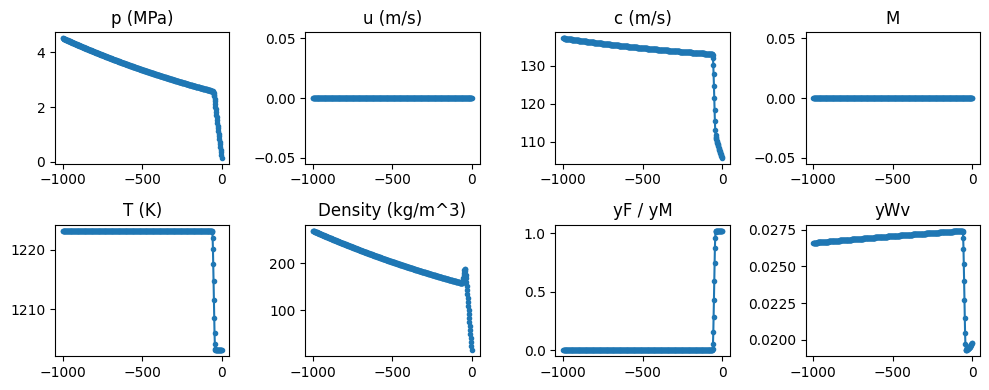

In [2]:
solver1D = readwritedatafiles.read_data_file(
  f"test_for_mario/test_infrasound_cond_0.pkl")

physics = solver1D.physics

U = solver1D.state_coeffs
x = solver1D.elem_helpers.x_elems
p = physics.compute_variable("Pressure", U)
u = physics.compute_variable("XVelocity", U)
c = physics.compute_variable("SoundSpeed", U)
T = physics.compute_variable("Temperature", U)
rho = U[...,0:3].sum(axis=-1, keepdims=True)
yF = U[...,7:8] / rho
yA = U[...,0:1] / rho
yWv = U[...,1:2] / rho
yM = U[...,2:3] / rho


# Make a bunch of plots

fig, axes = plt.subplots(2, 4, figsize=(10,4))

quant_list = [
  ("p (MPa)", p/1e6),
  ("u (m/s)", u),
  ("c (m/s)", c),
  ("M", u/c),
  ("T (K)", T),
  ("Density (kg/m^3)", rho),
  ("yF / yM", yF / yM),
  ("yWv", yWv),
]

for i, (name, vals) in enumerate(quant_list):
  # Select axis for subplot panel
  ax = axes.ravel()[i]
  ax.plot(x.ravel(), vals.ravel(), '.-')
  ax.set_title(name)

fig.tight_layout()
print(f"t = {solver1D.time:.6f} s")

In [5]:
# Function to read the i-th file for the 2D part
solver2D_from = lambda i: readwritedatafiles.read_data_file(
  f"test_for_mario/test_infrasound_atm1_{i}.pkl")

# Extract solver
solver2D = solver2D_from(0)

print("The shape of state_coeffs for 2D is:")
print(solver2D.state_coeffs.shape)


The shape of state_coeffs for 2D is:
(1215, 1, 10)


In [6]:
x_nodes = solver2D.mesh.node_coords[solver2D.mesh.elem_to_node_IDs, :]
x_nodes.shape

(1215, 3, 2)

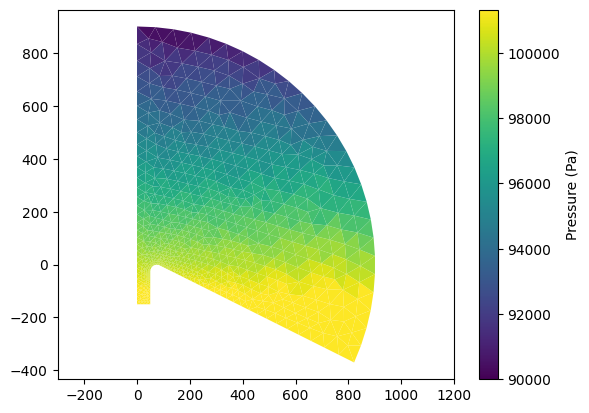

In [13]:
import processing.mdtools as mdtools
import matplotlib

fig = plt.figure()
ax = fig.axes

x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")

clims = (0.9e5, 1.01325e5)
mdtools.plot_mean(x, p, clims)

sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

In [17]:
import matplotlib.tri as tri
triangulation = tri.Triangulation(solver2D.mesh.node_coords[...,0],
                  solver2D.mesh.node_coords[...,1], 
                  triangles=solver2D.mesh.elem_to_node_IDs)

trifinder = triangulation.get_trifinder()

def find_elem_ID(x, y):
  ''' Returns element ID corresponding to given x and y. '''
  return trifinder(x, y)

## 2D1D BC

I noticed when comparing the input file tha  Mario shared with me versus the input file that Fred has originally shared with him, Mario's input file was missing the `MultiphasevpT2D1D` boundary condition which I think is also causing this below section of Fred's code to not work. 